# model の回収率のシミュレート

In [111]:
import numpy as np
import pandas as pd
#最大表示列数の指定
pd.set_option('display.max_columns', 300)

%matplotlib inline 
import matplotlib.pyplot as plt

plt.style.use('ggplot') 

In [112]:
race_df = pd.read_csv("./csv_cleaned/race_data.csv", sep=",")
horse_df = pd.read_csv("./csv_cleaned/horse_data.csv", sep=",")

In [113]:
import pickle
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)


def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data


In [114]:
predict_result = pd.read_csv("predict/simple_lgb_predicted_test.csv", sep=",")
predict_result.head(2)

,race_id,frame_number,horse_number,age,burden_weight,horse_weight,date,is_senba,is_mesu,is_osu,distance,horse_weight_dif,burden_weight_rate,ground_status,total_horse_number,weather_rain,weather_snow,pre_date_diff,is_rider_same,is_tamer_same,is_owner_same,rank_1,frame_number_1,age_1,burden_weight_1,goal_time_1,half_way_rank_1,last_time_1,horse_weight_1,is_down_1,distance_1,avg_velocity_1,horse_weight_dif_1,burden_weight_rate_1,ground_status_1,total_horse_number_1,weather_rain_1,weather_snow_1,pre_date_diff_1,is_rider_same_1,is_tamer_same_1,is_owner_same_1,interval_date_1,rank_2,frame_number_2,age_2,burden_weight_2,goal_time_2,half_way_rank_2,last_time_2,horse_weight_2,is_down_2,distance_2,avg_velocity_2,horse_weight_dif_2,burden_weight_rate_2,ground_status_2,total_horse_number_2,weather_rain_2,weather_snow_2,pre_date_diff_2,is_rider_same_2,is_tamer_same_2,is_owner_same_2,interval_date_2,rank_3,frame_number_3,age_3,burden_weight_3,goal_time_3,half_way_rank_3,last_time_3,horse_weight_3,is_down_3,distance_3,avg_velocity_3,horse_weight_dif_3,burden_weight_rate_3,ground_status_3,total_horse_number_3,weather_rain_3,weather_snow_3,pre_date_diff_3,is_rider_same_3,is_tamer_same_3,is_owner_same_3,interval_date_3,rank_f,win_horse_rate,win_times_rate,win_jusyo_rate,win_special_rate,win_plane_rate,win_turf_rate,win_dirt_rate,EI,rank_mf,win_horse_rate_mf,win_times_rate_mf,win_jusyo_rate_mf,win_special_rate_mf,win_plane_rate_mf,win_turf_rate_mf,win_dirt_rate_mf,EI_mf,rank_mmf,win_horse_rate_mmf,win_times_rate_mmf,win_jusyo_rate_mmf,win_special_rate_mmf,win_plane_rate_mmf,win_turf_rate_mmf,win_dirt_rate_mmf,EI_mmf,rank_fmf,win_horse_rate_fmf,win_times_rate_fmf,win_jusyo_rate_fmf,win_special_rate_fmf,win_plane_rate_fmf,win_turf_rate_fmf,win_dirt_rate_fmf,EI_fmf,is_tansyo,is_hukusyo,rank_category,predict_0_prob
0,201905010101,1.0,1.0,3.0,56.0,534.0,2019-01-26 10:10:00,0.0,0.0,1.0,1300.0,0.0,0.104869,1.0,16.0,0.0,0.0,109.0,1.0,1.0,1.0,16.0,6.0,2.0,55.0,87.9,16.0,39.3,516.0,0.0,1300.0,14.789534,0.0,0.106589,1.0,16.0,0.0,0.0,NaN,0.0,0.0,0.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,0.412556,0.082456,0.016949,0.067293,0.086607,0.033520,0.087851,0.92,16.0,0.469681,0.096372,0.090164,0.077644,0.104321,0.095192,0.099121,1.42,586.0,0.700000,0.106335,0.0,0.117978,0.106122,0.057143,0.131034,2.96,1149.0,0.833333,0.112069,0.000,0.083333,0.153846,0.073529,0.166667,2.95,0,0,1,0.113467
1,201905010101,8.0,15.0,3.0,55.0,486.0,2019-01-26 10:10:00,0.0,0.0,1.0,1300.0,4.0,0.113169,1.0,16.0,0.0,0.0,75.0,0.0,1.0,1.0,11.0,2.0,2.0,55.0,100.9,1.5,40.7,482.0,0.0,1600.0,15.857284,4.0,0.114108,4.0,16.0,0.0,0.0,NaN,0.0,0.0,0.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.0,0.337778,0.076066,0.070175,0.140127,0.068650,0.088514,0.055258,0.66,126.0,0.336022,0.059539,0.048913,0.062775,0.059204,0.064948,0.055122,0.79,1239.0,0.727273,0.157895,0.0,0.104167,0.192771,0.105263,0.197368,1.39,383.0,0.750000,0.112137,0.125,0.077273,0.126556,0.078740,0.133188,2.32,0,0,1,0.116328


In [115]:
# 予測値を100倍して見やすくする
predict_result["predict_0_prob"] = predict_result["predict_0_prob"]*100

In [116]:
predict_result.shape

(3996, 127)

## accuracy の計算
groupbyして、レースごとに確率の最も高い馬を見つける。
正解していたかを判定

In [117]:
# group by したデータフレームに対して行う処理
def check_is_correct_predict_is_tansyo(one_race_data):
    return one_race_data.loc[one_race_data['predict_0_prob'].idxmax()]['is_tansyo']
def check_is_correct_predict_is_hukusyo(one_race_data):
    return one_race_data.loc[one_race_data['predict_0_prob'].idxmax()]['is_hukusyo']

In [118]:
part_predict_result = predict_result[["race_id","date","horse_number", "is_hukusyo", "is_tansyo","predict_0_prob","rank_1"]]

is_tansyo = part_predict_result.groupby('race_id').apply(check_is_correct_predict_is_tansyo)
is_hukusyo = part_predict_result.groupby('race_id').apply(check_is_correct_predict_is_hukusyo)
print("tansyo accuracy: {}".format(is_tansyo.sum()/is_tansyo.size))
print("hukusyo accuracy: {}".format(is_hukusyo.sum()/is_hukusyo.size))

tansyo accuracy: 0.23333333333333334
hukusyo accuracy: 0.4925925925925926


# blending
お互いの欠点を補い合えるかも...？

In [119]:
'''
blend_df = predict_result.copy()
blend_df["blend"] = 0.5*blend_df["predict_is_tansyo"] + 0.5*blend_df["predict_is_hukusyo"]
blend_df = blend_df[["race_id","date","horse_number", "blend","is_hukusyo", "is_tansyo"]]

def blend_check_is_correct_predict_is_tansyo(one_race_data):
    return one_race_data.loc[one_race_data['blend'].idxmax()]['is_tansyo']
def blend_check_is_correct_predict_is_hukusyo(one_race_data):
    return one_race_data.loc[one_race_data['blend'].idxmax()]['is_hukusyo']

is_tansyo = blend_df.groupby('race_id').apply(blend_check_is_correct_predict_is_tansyo)
is_hukusyo = blend_df.groupby('race_id').apply(blend_check_is_correct_predict_is_hukusyo)
print("tansyo accuracy: {}".format(is_tansyo.sum()/is_tansyo.size))
print("hukusyo accuracy: {}".format(is_hukusyo.sum()/is_hukusyo.size))
'''

'\nblend_df = predict_result.copy()\nblend_df["blend"] = 0.5*blend_df["predict_is_tansyo"] + 0.5*blend_df["predict_is_hukusyo"]\nblend_df = blend_df[["race_id","date","horse_number", "blend","is_hukusyo", "is_tansyo"]]\n\ndef blend_check_is_correct_predict_is_tansyo(one_race_data):\n    return one_race_data.loc[one_race_data[\'blend\'].idxmax()][\'is_tansyo\']\ndef blend_check_is_correct_predict_is_hukusyo(one_race_data):\n    return one_race_data.loc[one_race_data[\'blend\'].idxmax()][\'is_hukusyo\']\n\nis_tansyo = blend_df.groupby(\'race_id\').apply(blend_check_is_correct_predict_is_tansyo)\nis_hukusyo = blend_df.groupby(\'race_id\').apply(blend_check_is_correct_predict_is_hukusyo)\nprint("tansyo accuracy: {}".format(is_tansyo.sum()/is_tansyo.size))\nprint("hukusyo accuracy: {}".format(is_hukusyo.sum()/is_hukusyo.size))\n'

## おかしいレースを取り除く
- 同着が存在する
- 前のレース情報が半分以上以上存在しない時
- 複勝3でオッズが０となるレース

In [120]:
merged_df = pd.merge(part_predict_result, race_df, on="race_id")
merged_df = pd.merge(merged_df, horse_df, on=['race_id','horse_number'])

merged_df['tansyo_return'] = merged_df['is_tansyo']*merged_df['tansyo'] - 100
merged_df["hukusyo_return"] = (merged_df["rank"]==1)*merged_df["hukusyo_first"] + (merged_df["rank"]==2)*merged_df["hukusyo_second"] + (merged_df["rank"]==3)*merged_df["hukusyo_third"]  - 100

In [121]:
merged_df.head(2)

,race_id,date_x,horse_number,is_hukusyo,is_tansyo,predict_0_prob,rank_1,race_round,ground_status,date_y,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,distance_x,weather_rain,weather_snow,rank,frame_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date,is_down,is_senba,is_mesu,is_osu,distance_y,avg_velocity,horse_weight_dif,burden_weight_rate,tansyo_return,hukusyo_return
0,201905010101,2019-01-26 10:10:00,1.0,0,0,11.346673,16.0,1,1,2019-01-26 10:10:00,16,8,16,2,3,5,10,1880,280,110,120,640,2110,700,650,200,6360,1560,18190,1300,0,0,6,1,2016100630,3,56.0,1150,82.4,1.0,39.7,8.5,4.0,534.0,1076,238033,2019-01-26 10:10:00,0,0,0,1,1300,15.776699,0.0,0.104869,-100,-100
1,201905010101,2019-01-26 10:10:00,15.0,0,0,11.632785,11.0,1,1,2019-01-26 10:10:00,16,8,16,2,3,5,10,1880,280,110,120,640,2110,700,650,200,6360,1560,18190,1300,0,0,7,8,2016101490,3,55.0,1169,83.0,6.5,39.3,6.3,3.0,486.0,1088,547800,2019-01-26 10:10:00,0,0,0,1,1300,15.662651,4.0,0.113169,-100,-100


In [122]:
print(merged_df["tansyo"].sort_values().unique()[0:3])
print(merged_df["hukusyo_first"].sort_values().unique()[0:3])
print(merged_df["hukusyo_second"].sort_values().unique()[0:3])
print(merged_df["hukusyo_third"].sort_values().unique()[0:3])

[110 120 130]
[100 110 120]
[110 120 130]
[  0 110 120]


In [123]:
def remove_same(one_horse_data):
    #  数レース分の情報を結合
    result_df = one_horse_data.copy()
    horse_number = result_df['horse_number'].mean()
    if result_df["rank"].duplicated().sum() or result_df["rank_1"].isnull().sum()>horse_number/2 or (result_df["hukusyo_third"].isnull().sum()>0):
        return 
    else:
        return result_df

In [124]:
print(merged_df.shape)
removed = merged_df.groupby("race_id").apply(remove_same)
print(removed.shape)

(3996, 57)
(1828, 57)


## 可視化

In [125]:
removed = removed.reset_index(drop=True)
removed.head()

,race_id,date_x,horse_number,is_hukusyo,is_tansyo,predict_0_prob,rank_1,race_round,ground_status,date_y,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,distance_x,weather_rain,weather_snow,rank,frame_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date,is_down,is_senba,is_mesu,is_osu,distance_y,avg_velocity,horse_weight_dif,burden_weight_rate,tansyo_return,hukusyo_return
0,201905010107,2019-01-26 13:30:00,2.0,0,0,12.325528,9.0,7,1,2019-01-26 13:30:00,16,7,14,5,10,7,13,640,220,190,460,1070,1250,500,1300,1340,2380,5420,25790,1400,0,0,9,1,2015105432,4,56.0,5575,87.3,3.5,38.2,13.0,7.0,490.0,399,854800,2019-01-26 13:30:00,0,0,0,1,1400,16.036655,10.0,0.114286,-100,-100
1,201905010107,2019-01-26 13:30:00,13.0,1,0,12.081854,9.0,7,1,2019-01-26 13:30:00,16,7,14,5,10,7,13,640,220,190,460,1070,1250,500,1300,1340,2380,5420,25790,1400,0,0,3,7,2014100916,5,56.0,1162,86.6,7.0,37.3,16.6,8.0,452.0,1051,158033,2019-01-26 13:30:00,0,0,0,1,1400,16.166282,4.0,0.123894,-100,360
2,201905010107,2019-01-26 13:30:00,16.0,0,0,19.879194,5.0,7,1,2019-01-26 13:30:00,16,7,14,5,10,7,13,640,220,190,460,1070,1250,500,1300,1340,2380,5420,25790,1400,0,0,4,8,2015100644,4,56.0,1122,86.9,12.0,37.0,4.6,1.0,494.0,1088,798008,2019-01-26 13:30:00,0,0,0,1,1400,16.110472,-4.0,0.113360,-100,-100
3,201905010107,2019-01-26 13:30:00,15.0,0,0,22.328773,3.0,7,1,2019-01-26 13:30:00,16,7,14,5,10,7,13,640,220,190,460,1070,1250,500,1300,1340,2380,5420,25790,1400,0,0,12,8,2015104514,4,54.0,1158,87.5,3.5,38.4,51.2,10.0,466.0,1124,308033,2019-01-26 13:30:00,0,0,0,1,1400,16.000000,16.0,0.115880,-100,-100
4,201905010107,2019-01-26 13:30:00,7.0,0,0,11.661989,6.0,7,1,2019-01-26 13:30:00,16,7,14,5,10,7,13,640,220,190,460,1070,1250,500,1300,1340,2380,5420,25790,1400,0,0,11,4,2012101289,7,57.0,641,87.4,15.5,37.4,68.4,12.0,480.0,1165,580007,2019-01-26 13:30:00,0,1,0,0,1400,16.018307,-4.0,0.118750,-100,-100


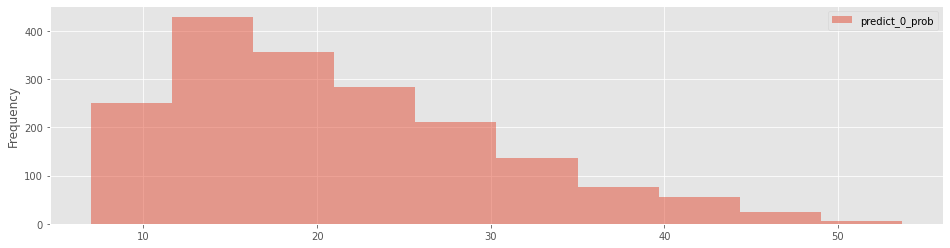

In [126]:
# predict_0_prob の分布についてヒストグラム
removed.plot(kind='hist', y='predict_0_prob' , bins=10, figsize=(16,4), alpha=0.5)

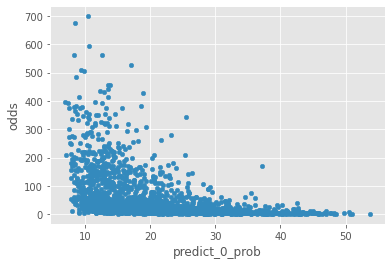

In [127]:
# オッズと予測値
removed.plot(kind='scatter', x='predict_0_prob', y='odds')

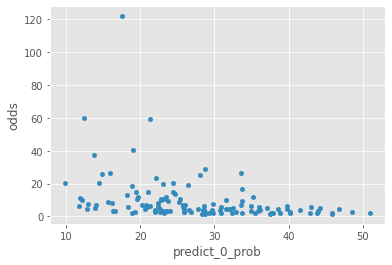

In [128]:
# 実際に1位になったものについてのオッズと予測値
removed[removed["rank"]==1].plot(kind='scatter', x='predict_0_prob', y='odds')

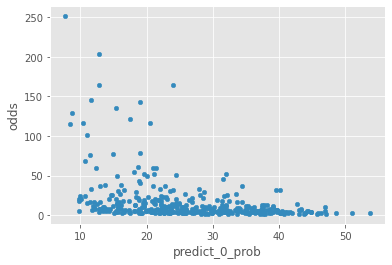

In [129]:
# 実際に複勝圏内になったものについてのオッズと予測値
removed[removed["rank"]<=3].plot(kind='scatter', x='predict_0_prob', y='odds')

## 的中率の計算(実際に1位や３位以内であった確率）

In [130]:
# cut
removed["predict_0_prob_cut"] = pd.cut(removed["predict_0_prob"], 10)

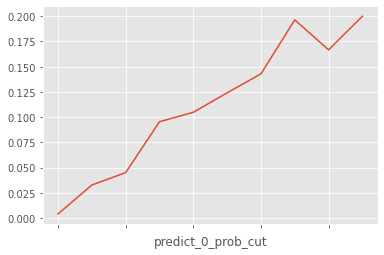

In [131]:
# tansyo
def right_rate_tansyo(one_cut):
    return one_cut["is_tansyo"].sum()/len(one_cut)
    
removed.groupby("predict_0_prob_cut").apply(right_rate_tansyo).plot()

40%以上の確率ならあまり精度は変わらない？
or 90% 前後なら高い

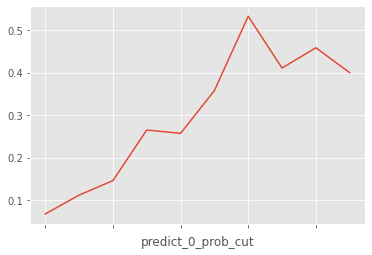

In [132]:
# hukusyo
def right_rate_hukusyo(one_cut):
    return one_cut["is_hukusyo"].sum()/len(one_cut)
    
removed.groupby("predict_0_prob_cut").apply(right_rate_hukusyo).plot()

## 回収率の計算

### 単純に確率が高いものを買い続けた時

In [133]:
def get_return_by_top(one_race):
    tmp = one_race.reset_index()
    return tmp.loc[tmp['predict_0_prob'].idxmax(),['tansyo_return','hukusyo_return','odds','date','predict_0_prob']]

race_result = removed.groupby("race_id").apply(get_return_by_top)
race_result = race_result.sort_values("date")
race_result = race_result.set_index("date")

### 単勝

num:  124
win:  22
win_rate:  0.1774193548387097


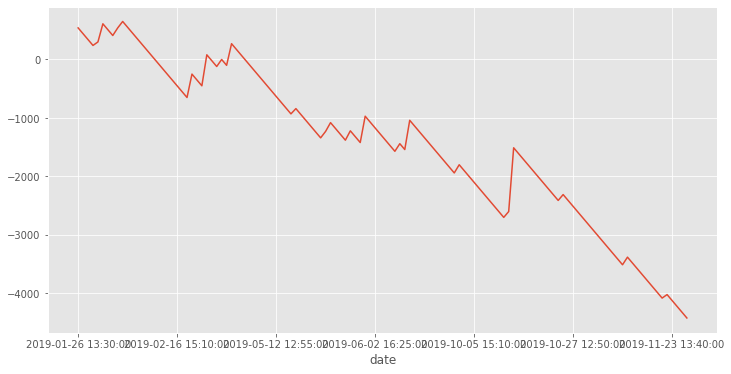

In [134]:
# 単純に買い続けたとき
simple = race_result["tansyo_return"].cumsum()

num = race_result.shape[0]
win = race_result[race_result["tansyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)

simple.plot(figsize=(12, 6))

num:  111
win:  20
win_rate:  0.18018018018018017


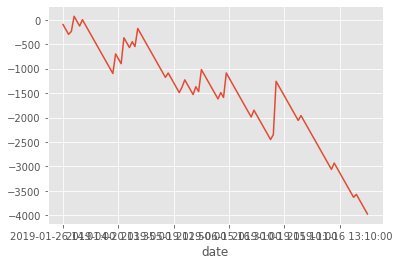

In [135]:
# predict_0_prob　がある程度あるときだけ
per = 30
simple = race_result.loc[(race_result["predict_0_prob"]>per), 'tansyo_return'].cumsum()

num = race_result.loc[(race_result["predict_0_prob"]>per), 'tansyo_return'].shape[0]
win = race_result.loc[(race_result["predict_0_prob"]>per), 'tansyo_return'][race_result["tansyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)

simple.plot()

### 複勝

num:  124
win:  49
win_rate:  0.3951612903225806


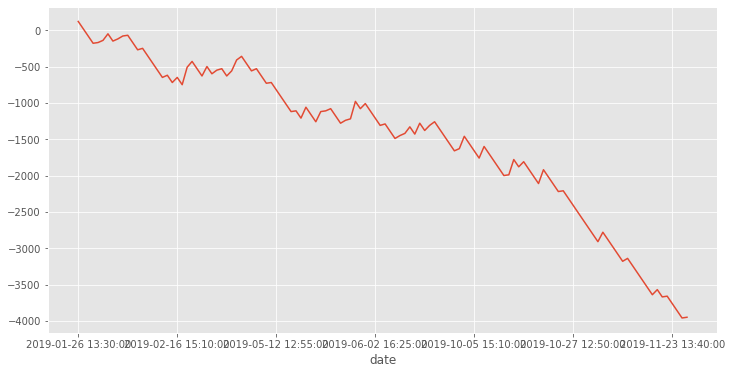

In [136]:
# 単純に買い続けたとき
simple = race_result["hukusyo_return"].cumsum()
num = race_result.shape[0]
win = race_result[race_result["hukusyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)
simple.plot(figsize=(12, 6))

num:  111
win:  45
win_rate:  0.40540540540540543


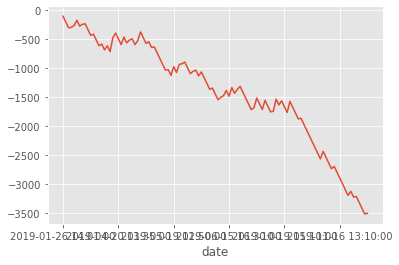

In [137]:
# 予測値を含める
simple = race_result.loc[(race_result["predict_0_prob"]>30), 'hukusyo_return'].cumsum()
num = race_result.loc[(race_result["predict_0_prob"]>per), 'hukusyo_return'].shape[0]
win = race_result.loc[(race_result["predict_0_prob"]>per), 'hukusyo_return'][race_result["hukusyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)
simple.plot()

### 二番目予想との差が大きい時

In [138]:
def get_return_by_top(one_race):
    tmp = one_race.reset_index()
    tmp = tmp.sort_values("predict_0_prob")
    tmp["diff_big"] = tmp["predict_0_prob"].iat[-1] - tmp["predict_0_prob"].iat[-2]
    tmp["is_diff_big"] = (tmp["diff_big"]>10)*1.
    return tmp.loc[tmp['predict_0_prob'].idxmax(),['tansyo_return','hukusyo_return','odds','date','predict_0_prob',"is_diff_big"]]

race_result = removed.groupby("race_id").apply(get_return_by_top)
race_result = race_result.sort_values("date")
race_result = race_result.set_index("date")

In [139]:
race_result.head(3)

,tansyo_return,hukusyo_return,odds,predict_0_prob,is_diff_big
date,,,,,
2019-01-26 13:30:00,540,120,6.4,28.576250,0.0
2019-01-26 14:01:00,-100,-100,12.6,44.468838,0.0
2019-01-26 14:35:00,-100,-100,3.6,41.130709,0.0


#### 単勝

num:  124
win:  22
win_rate:  0.1774193548387097


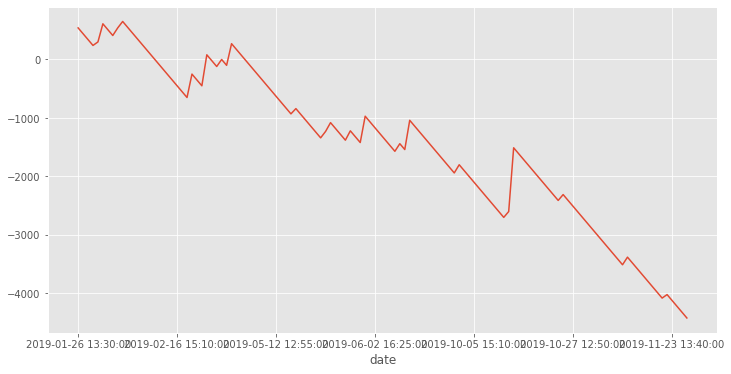

In [140]:
# 単純に買い続けたとき
simple = race_result["tansyo_return"].cumsum()

num = race_result.shape[0]
win = race_result[race_result["tansyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)

simple.plot(figsize=(12, 6))

num:  16
win:  4
win_rate:  0.25


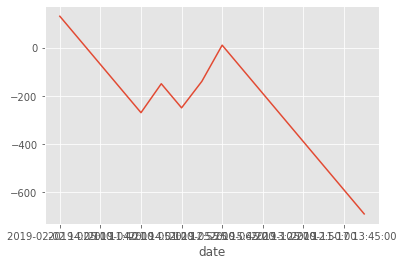

In [141]:
# 予測値を含める
simple = race_result.loc[(race_result["is_diff_big"]>=1.0), 'tansyo_return'].cumsum()
num = race_result.loc[(race_result["is_diff_big"]>=1.0), 'tansyo_return'].shape[0]
win = race_result.loc[(race_result["is_diff_big"]>=1.0), 'tansyo_return'][race_result["tansyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)
simple.plot()

### 複勝

num:  124
win:  49
win_rate:  0.3951612903225806


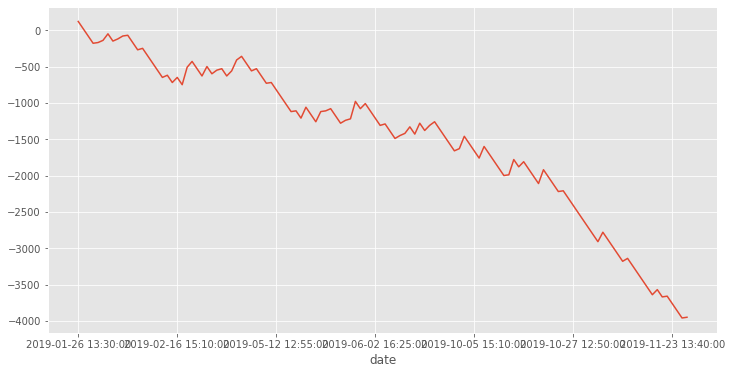

In [142]:
# 単純に買い続けたとき
simple = race_result["hukusyo_return"].cumsum()
num = race_result.shape[0]
win = race_result[race_result["hukusyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)
simple.plot(figsize=(12, 6))

num:  16
win:  7
win_rate:  0.4375


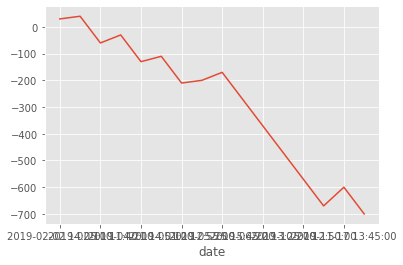

In [143]:
# 予測値を含める
simple = race_result.loc[(race_result["is_diff_big"]>=1.0), 'hukusyo_return'].cumsum()
num = race_result.loc[(race_result["is_diff_big"]>=1.0), 'hukusyo_return'].shape[0]
win = race_result.loc[(race_result["is_diff_big"]>=1.0), 'hukusyo_return'][race_result["hukusyo_return"]>0].shape[0]
win_rate = win/num
print("num: ",num)
print("win: ",win)
print("win_rate: ",win_rate)
simple.plot()